In [ ]:
# Chen Yanrong

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path="/content/drive/My Drive/CS5228 Project"
os.chdir(path)
os.listdir(path)

['test_processed.csv', 'train_processed.csv']

## Modeling

In [ ]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 29.8 MB/s eta 0:00:00


In [ ]:
# essentials
import numpy as np
import pandas as pd
import math
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# models
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from tensorflow_decision_forests.keras import RandomForestModel
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
train = pd.DataFrame(pd.read_csv("train_processed.csv"))
test = pd.DataFrame(pd.read_csv("test_processed.csv"))
print("Number of samples: training(%d), testing(%d)" % (len(train), len(test)))

Number of samples: training(431706), testing(107934)


In [ ]:
train.dtypes

month                           int64
town                            int64
street_name                     int64
storey_range                    int64
floor_area_sqm                float64
flat_model                      int64
lease_commence_date             int64
latitude                      float64
longitude                     float64
subzone                         int64
planning_area                   int64
population                      int64
mrt                             int64
sp_mall                         int64
secondary_school                int64
primary_school                  int64
hawker                          int64
commercial_centre               int64
remaining_lease                 int64
flat_type_1-room                int64
flat_type_2-room                int64
flat_type_3-room                int64
flat_type_4-room                int64
flat_type_5-room                int64
flat_type_executive             int64
flat_type_multi generation      int64
region_centr

In [ ]:
train_y = train.pop('resale_price').values
train_y.shape

(431706,)

In [ ]:
train.describe()

,month,town,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,...,flat_type_3-room,flat_type_4-room,flat_type_5-room,flat_type_executive,flat_type_multi generation,region_central region,region_east region,region_north region,region_north-east region,region_west region
count,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,...,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.000000,431706.00000,431706.000000
mean,111.121872,13.510540,602.835047,3.435968,96.970537,7.888822,23.421120,1.364939,103.836488,85.952762,...,0.291187,0.392841,0.228609,0.075797,0.000429,0.190653,0.179110,0.178059,0.19879,0.253388
std,72.874516,8.278212,319.443883,2.681503,25.190485,3.817455,10.253932,0.042830,0.073525,46.424684,...,0.454310,0.488383,0.419937,0.264673,0.020697,0.392816,0.383445,0.382563,0.39909,0.434952
min,0.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,1.270380,103.685228,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,47.000000,5.000000,345.000000,2.000000,74.000000,4.000000,17.000000,1.336154,103.772439,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,105.000000,13.000000,620.000000,4.000000,99.000000,7.000000,22.000000,1.358958,103.840160,94.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,170.000000,22.000000,880.000000,5.000000,114.000000,11.000000,31.000000,1.389004,103.895779,123.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,250.000000,25.000000,1102.000000,24.000000,280.000000,19.000000,53.000000,1.457071,103.987805,154.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Feature Correlation Analysis

From the following heatmap shows the correlations between every 2 features. 

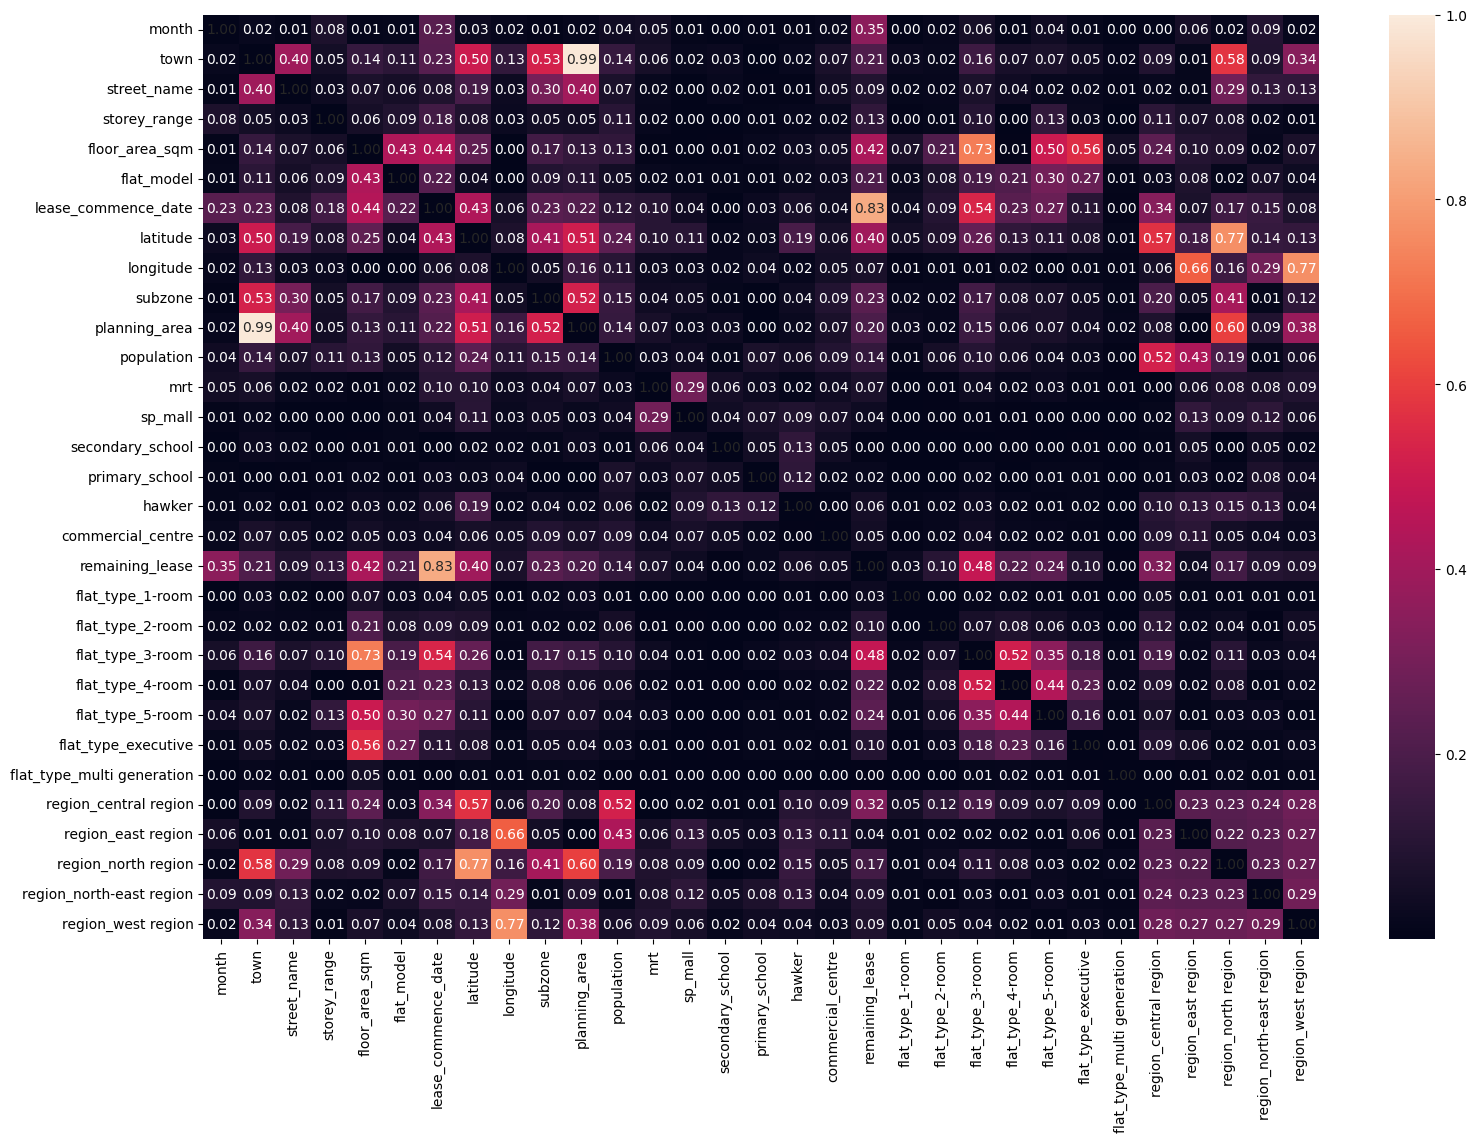

In [ ]:
feature_corr = train.corr().abs()

plt.subplots(figsize=(18, 12))
sns.heatmap(feature_corr, annot=True, fmt=".2f" )
sns.heatmap(feature_corr, mask=feature_corr < 1, cbar=False)
plt.show()

We can see that the correlaion between the feature 'town' and 'planning_area' approximately equals to 1 (in fact, they are the same), so we drop the feature 'planning_area'.

Also, we have extracted the useful information 'remaining_lease' from 'month' and 'lease_commence_date'. The 'lease_commence_date' is not intuitive and should be dropped.

In [ ]:
train = train.drop(columns=['planning_area', 'lease_commence_date'])
test = test.drop(columns=['planning_area', 'lease_commence_date'])

In [ ]:
train_X = train.values
test_X = test.values

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)

(431706, 29)
(107934, 29)
(431706,)


## Construct a Stacking Model

Here we try to build a 2-layer stacking model. 2 strong regressors *LightGBM* and *RandomForest* are selected as the first-layer models, and *SVM* is selected as the second-layer model.

The first-layer models are both tree-based models, so standardization is not necessary.

In [ ]:
RANDOM_SEED = 5228
np.random.seed(RANDOM_SEED)

n_estimators = 30

# candidate models
gbm = lgb.LGBMRegressor(objective='regression', n_estimators=n_estimators)
rfr = RandomForestRegressor(n_estimators=n_estimators, random_state=RANDOM_SEED)
#rfr = RandomForestModel()
gbr = GradientBoostingRegressor(n_estimators=n_estimators)
svr = SVR()
rdg = Ridge(alpha=0.3)
lss = Lasso(alpha=0.3)
# model = RidgeCV(alphas=[0.1, 1.0, 10.0])  

In [ ]:
for reg, label in zip([gbm, rfr, gbr], ['LightGBM', 'Random Forest', 'Gradient Boosting']):
    MAEs = cross_val_score(reg, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')
    print("MAE Score: %0.2f (+/- %0.2f) [%s]" % (MAEs.mean(), MAEs.std(), label))

MAE Score: -25272.06 (+/- 110.79) [LightGBM]
MAE Score: -12612.98 (+/- 21.77) [Random Forest]
MAE Score: -33903.39 (+/- 232.79) [Gradient Boosting]


In [ ]:
rfr_ = RandomForestRegressor(n_estimators=n_estimators, random_state=RANDOM_SEED+1)
stack = StackingCVRegressor(regressors=(gbm, rfr), meta_regressor=rdg)
stack_1 = StackingCVRegressor(regressors=(gbm, rfr), meta_regressor=lss)
stack_2 = StackingCVRegressor(regressors=(rfr_, rfr), meta_regressor=rdg)
stack_3 = StackingCVRegressor(regressors=(rfr_, rfr), meta_regressor=lss)

In [ ]:
for reg, label in zip([stack, stack_1, stack_2, stack_3], ['stack_0', 'stack_1', 'stack_2', 'stack_3']):
    MAEs = cross_val_score(reg, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')
    print("MAE Score: %0.2f (+/- %0.2f) [%s]" % (MAEs.mean(), MAEs.std(), label))

MAE Score: -12606.31 (+/- 22.95) [stack_0]
MAE Score: -12606.23 (+/- 22.91) [stack_1]
MAE Score: -12468.26 (+/- 30.14) [stack_2]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.743e+13, tolerance: 5.830e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.700e+13, tolerance: 5.818e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.758e+13, tolerance: 5.820e+11

MAE Score: -12468.59 (+/- 30.23) [stack_3]


In [ ]:
# standardization
scaler = StandardScaler()
scaler.fit(train_X)
train_X_norm = scaler.transform(train_X)

In [ ]:
# decomposition
pca = PCA(n_components=train_X.shape[1])
pca.fit(train_X_norm)
print(pca.explained_variance_ratio_)

[1.32698761e-01 8.33201578e-02 7.93776200e-02 6.16370237e-02
 5.89847302e-02 5.14783941e-02 4.33964335e-02 4.22853046e-02
 4.06810600e-02 3.53987022e-02 3.50713606e-02 3.48603246e-02
 3.44824755e-02 3.39315036e-02 3.16846871e-02 3.04074088e-02
 2.94033881e-02 2.70184354e-02 2.35148509e-02 2.26582577e-02
 2.09099880e-02 1.68173697e-02 1.27406378e-02 1.10146599e-02
 3.21387519e-03 1.64180178e-03 1.37078806e-03 2.61702162e-32
 5.03683571e-33]


In [ ]:
# decomposition
pca = PCA(n_components=train_X.shape[1]-8)
train_X_dec = pca.fit_transform(train_X_norm)
print(sum(pca.explained_variance_ratio_))

0.9532008675629479


In [ ]:
train_X_dec.shape 

(431706, 21)

In [ ]:
MAEs = cross_val_score(rfr, train_X_dec, train_y, cv=5, scoring='neg_mean_absolute_error')
print("MAE Score: %0.2f (+/- %0.2f) [%s]" % (MAEs.mean(), MAEs.std(), 'Random Forest with dimension-reduced input'))

MAE Score: -26604.48 (+/- 250.09) [Random Forest with dimension-reduced input]


In [ ]:
rfr = RandomForestRegressor(n_estimators=int(2*n_estimators), random_state=RANDOM_SEED)
MAEs = cross_val_score(rfr, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')
print("MAE Score: %0.2f (+/- %0.2f) [%s]" % (MAEs.mean(), MAEs.std(), 'Random Forest with double estimators'))

MAE Score: -12473.83 (+/- 25.97) [Random Forest with double estimators]


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Sun Apr  9 15:33:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git 
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 385 (delta 86), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (385/385), 105.74 KiB | 611.00 KiB/s, done.
Resolving deltas: 100% (188/188), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 4.5 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************



In [ ]:
! bash rapidsai-csp-utils/colab/update_gcc.sh 
import os 
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Found existing installation: cupy-cuda11x 11.0.0
Uninstalling cupy-cuda11x-11.0.0:
  Successfully uninstalled cupy-cuda11x-11.0.0
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 http://ppa.launchpad.net/ubuntu-too

In [ ]:
import condacolab 
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...


In [ ]:
import condacolab 
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py stable

流式输出内容被截断，只能显示最后 5000 行内容。














six-1.16.0           | 14 KB     | ########## | 100% 

















xorg-renderproto-0.1 | 9 KB      | ########## | 100% 


















folium-0.14.0        | 71 KB     | ##2        |  22% 













multidict-6.0.4      | 51 KB     | ########## | 100% 













multidict-6.0.4      | 51 KB     | ########## | 100% 














matplotlib-inline-0. | 12 KB     | ########## | 100% 



















 ... (more hidden) ...




pywavelets-1.4.1     | 3.5 MB    | ########## | 100% 




pywavelets-1.4.1     | 3.5 MB    | ########## | 100% 



















 ... (more hidden) ...















oauthlib-3.2.2       | 90 KB     | ########## | 100% 















oauthlib-3.2.2       | 90 KB     | ########## | 100% 
















six-1.16.0           | 14 KB     | ########## | 100% 

















xorg-renderproto-0.1 | 9 KB      | ########## | 100% 


















folium-0.14.0        | 71 KB     | ########## | 100% 











In [ ]:
#!pip install --upgrade cupy

In [ ]:
import cudf
import cuml

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import gc

In [ ]:
train = pd.DataFrame(pd.read_csv("train_processed.csv"))
test = pd.DataFrame(pd.read_csv("test_processed.csv"))

train_y = train.pop('resale_price').values

train = train.drop(columns=['planning_area', 'lease_commence_date'])
test = test.drop(columns=['planning_area', 'lease_commence_date'])

train_X = train.values
test_X = test.values

In [ ]:
test_X_gdf = cudf.from_pandas(test)

In [ ]:
def evaluate(y_true, y_pred, metric='MAE'):
  # metrics = [mean_absolute_error, mean_squared_error, r2_score]
  if metric.upper() == 'MAE':
    return mean_absolute_error(y_true, y_pred)
  elif metric.upper() == 'MSE':
    return mean_squared_error(y_true, y_pred)
  elif metric.upper() == 'RMSE':
    return math.sqrt(mean_squared_error(y_true, y_pred))
  elif metric.upper() == 'R2':
    return r2_score(y_true, y_pred)
  else:
    print("Error: unsupported metric %s" % metric)
    return None


def cross_validate_gpu(df_X, df_y, model_gpu, metrics, cv=5, random_state=None):
  kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
  results = {m:[] for m in metrics}
  for train_ind, val_ind in kf.split(df_X, df_y):
    train_X_gdf, train_y_gs, val_X_gdf, val_y_gs = df_X.iloc[train_ind], df_y.iloc[train_ind], df_X.iloc[val_ind], df_y.iloc[val_ind]

    train_X_gdf = cudf.from_pandas(train_X_gdf)
    train_y_gs = cudf.Series(train_y_gs)
    val_X_gdf = cudf.from_pandas(val_X_gdf)
    val_y_gs = cudf.Series(val_y_gs)

    model_gpu = model_gpu.fit(train_X_gdf, train_y_gs)
    pred = model_gpu.predict(val_X_gdf).to_numpy()
    for m in metrics:
      results[m].append(evaluate(val_y_gs.to_numpy(), pred, metric=m))
  for key, value in results.items():
    results[key] = np.mean(value)
  
  del kf, train_ind, val_ind, train_X_gdf, train_y_gs, val_X_gdf, val_y_gs, model_gpu, pred, m, key, value
  gc.collect()

  return results


class ParamsSearcher():
  def __init__(self, df_X, df_y, scorings, cv=5):
    self.X = df_X
    self.y = df_y
    self.scorings = scorings
    self.cv = cv
    self.grid = None
    self.best_param = None
    self.best_scores = None
    self.best_model = None
  
  def cross_validate(self, model, random_state=None):
    return cross_validate_gpu(self.X, self.y, model, self.scorings, cv=self.cv, random_state=random_state)

  def get_param(self, idx):
    idx = list(idx)[::-1]
    param = {}
    for key, value in self.grid.items():
      i = idx.pop()
      param[key] = value[i]

    del key, value 
    gc.collect()

    return param
  
  def grid_search(self, params_dict, random_state=None):
    self.grid = params_dict
    n_scorings = len(self.scorings)
    shape = []
    for _, value in self.grid.items():
      shape.append(len(value))
    scores_arr = np.zeros([n_scorings] + shape)
    #temp = []
    for i, _ in np.ndenumerate(scores_arr[0]):
      #print(i)
      param = self.get_param(i)
      model = cuml.ensemble.RandomForestRegressor(**param)
      scores = self.cross_validate(model, random_state=random_state)
      scores_arr[(list(range(n_scorings)), *i)] = np.array(list(scores.values()))
      #temp.append(np.array(list(scores.values())))
    #temp = np.stack(temp, axis=-1)
    #scores_arr = temp.reshape([n_scorings] + shape)
    
    votes = []
    for j in range(n_scorings):
      if self.scorings[j].upper() ==  'R2':
        votes.append(np.unravel_index(np.argmin(abs(1-scores_arr[j])), scores_arr[j].shape))
      else:
        votes.append(np.unravel_index(np.argmin(scores_arr[j]), scores_arr[j].shape))

    max_idx = max(votes, key=votes.count)
    print(max_idx)
    self.best_param = self.get_param(max_idx)
    self.best_scores = dict(zip(self.scorings, scores_arr[(list(range(n_scorings)), *max_idx)].tolist()))
    self.best_model = cuml.ensemble.RandomForestRegressor(**self.best_param).fit(self.X, self.y)

    del n_scorings, shape, _, value, i, param, model, scores, scores_arr, votes, j, max_idx
    gc.collect()

In [ ]:
scorings = ['MAE', 'MSE', 'R2']
params_dict = {'n_estimators': [100, 200, 300, 400]}
PS = ParamsSearcher(train, pd.Series(train_y), scorings)
PS.grid_search(params_dict, random_state=5228)
print(PS.best_param)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/c

(3,)
{'n_estimators': 400}


/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


In [ ]:
print(PS.best_scores)

{'MAE': 14685.497014158807, 'MSE': 435518830.1883482, 'R2': 0.9741736964815713}


In [ ]:
scorings = ['MAE', 'MSE', 'R2']
params_dict = {'n_estimators': [500, 600, 700, 800]}
PS = ParamsSearcher(train, pd.Series(train_y), scorings)
PS.grid_search(params_dict, random_state=5228)
print(PS.best_param)
print(PS.best_scores)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/c

(3,)
{'n_estimators': 800}
{'MAE': 14679.23715030463, 'MSE': 435126928.32320225, 'R2': 0.9741969734042162}


/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


In [ ]:
scorings = ['MAE', 'MSE', 'R2']
params_dict = {'n_estimators': [400],
        'max_features': [0.5, 'sqrt', 'log2']}
PS = ParamsSearcher(train, pd.Series(train_y), scorings)
PS.grid_search(params_dict, random_state=5228)
print(PS.best_param)
print(PS.best_scores)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/c

(0, 0)


/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


{'n_estimators': 400, 'max_features': 0.5}
{'MAE': 21473.46109057078, 'MSE': 878868556.6992905, 'R2': 0.9478819478296693}


In [ ]:
scorings = ['MAE', 'MSE', 'R2']
params_dict = {'n_estimators': [400],
        'min_samples_leaf': [3, 5, 9, 15]}
PS = ParamsSearcher(train, pd.Series(train_y), scorings)
PS.grid_search(params_dict, random_state=5228)
print(PS.best_param)
print(PS.best_scores)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/c

(0, 0)
{'n_estimators': 400, 'min_samples_leaf': 3}
{'MAE': 14696.211473822103, 'MSE': 437164199.3775846, 'R2': 0.9740760021743708}


/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


In [ ]:
import pickle

model = cuml.ensemble.RandomForestRegressor(n_estimators=400)

train_X_gdf = cudf.from_pandas(train)
train_y_gs = cudf.Series(pd.Series(train_y))

model = model.fit(train_X_gdf, train_y_gs)
pickle.dump(model, open("final_model.pkl", "wb"))

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


In [ ]:
pred = model.predict(test_X_gdf).to_numpy()
#pred = np.expm1(pred)
pred = pd.DataFrame({'Predicted': pred,
            'ID': list(range(len(test_X)))})
print(pred)
pred.to_csv("test_pred.csv", index=False, header=True)

            Predicted      ID
0       189867.873905       0
1       308141.541453       1
2       125336.720707       2
3       316363.768227       3
4       330592.107205       4
...               ...     ...
107929  339196.553466  107929
107930  302988.155169  107930
107931  174779.275000  107931
107932  245771.935613  107932
107933  328246.450003  107933

[107934 rows x 2 columns]


In [ ]:
#test_input = 
#test_y = func(test_y)